In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import math
import os
from scipy.optimize import curve_fit, minimize
import matplotlib.colors as mcolors
from sklearn.metrics import r2_score

In [3]:
final_structure_name_list = ['FumCALF-20_MACE_opt_pacman']
print("Current Directory:", os.getcwd())

Current Directory: C:\Users\Process Guy\Desktop\Biogas\fitting


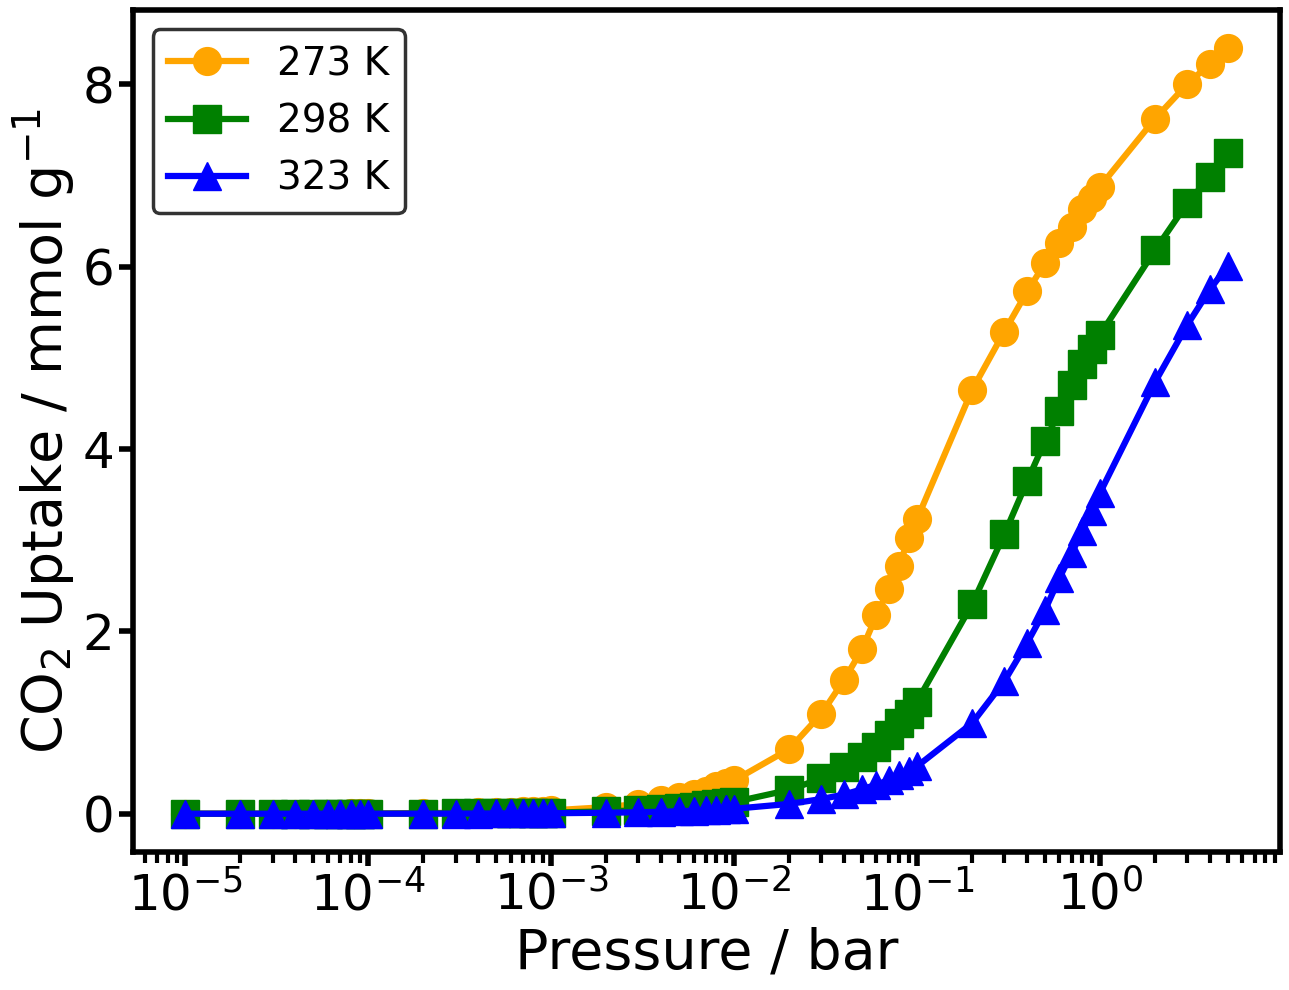

FumCALF-20_MACE_opt_pacman finish


In [4]:
for name in final_structure_name_list:

    plt.figure(figsize=(13,10))
    ax1 = plt.subplot(1,1,1)
    
    CO2_data_273 = str(name)+"_CO2_273K.csv"
    CO2_data_298 = str(name)+"_CO2_298K.csv"
    CO2_data_323 = str(name)+"_CO2_323K.csv"
        
    df1 = pd.read_csv(CO2_data_273)
    df2 = pd.read_csv(CO2_data_298)
    df3 = pd.read_csv(CO2_data_323)

    ax1.plot(df1["P"]/100000, df1["q"], marker="o", lw=4.5, markersize=20, color='orange', label='273 K')
    ax1.plot(df2["P"]/100000, df2["q"], marker="s", lw=4.5, markersize=20, color='green', label='298 K')
    ax1.plot(df3["P"]/100000, df3["q"], marker="^", lw=4.5, markersize=20, color='blue', label='323 K')

    #ax1.set_xlim((-0.05,1.1))
    #ax.set_xticks(np.arange(0,100,10))
    #ax1.set_ylim((0,10))
    plt.semilogx()
    
    plt. xticks(fontsize=36)
    plt. tick_params(axis='both', width=4, length=10)
    plt. tick_params(axis='both', which='minor',width=3, length=8)
    plt. yticks(fontsize=36)

    for direction in ['left','top','right','bottom']:
        ax1.spines[direction].set_linewidth(4)
    
    ax1.set_ylabel('CO$_{2}$ Uptake / mmol g$^{{\u2212}1}$', fontsize=40)
    ax1.set_xlabel('Pressure / bar',fontsize=40) 
    
    leg=plt.legend(frameon=True, fontsize=28, loc='best')
    #bbox_to_anchor=(1, 0.18)
    leg.get_frame_on()
    leg.get_frame().set_linewidth(2.5)
    leg.get_frame().set_edgecolor('black')
    
    plt.tight_layout()
    plt.savefig(f"./{name}_single_component_CO2_isotherms.png",dpi=300) ###
    plt.show()
    print(f"{name} finish")
    

In [5]:
## original dual-site Langmuir (DSL) model

def DL_eq_ori(P, T, qb1, qd1, b1, d1, Ub1, Ud1):
    
    """
    Input 
    P: absolute pressure (Pa)
    T: absolute temperture (K)
    
    qb1: saturation loading for site 1 (mmol/g)
    qd1: saturation loading for site 2 (mmol/g)
    b1: Langmuir constant for site 1 (1/Pa)
    d1: Langmuir constant for site 2 (1/Pa)
    Ub1: heat of adsorption for site 1 (J/mol)
    Ub2: heat of adsorption for site 2 (J/mol)
    
    Output
    q: loading (mmol/g)
    """
    
    q=qb1*b1*np.exp(-Ub1/8.314/T)*P/(1+b1*np.exp(-Ub1/8.314/T)*P) + qd1*d1*np.exp(-Ud1/8.314/T)*P/(1+d1*np.exp(-Ud1/8.314/T)*P)
    
    return q

## dual-site Langmuir (DSL) model at reference temperature (360.5 K in my case)

def DL_eq_ref(P, qb1, qd1, b1, d1, Ub1, Ud1):
    
    """
    Input 
    P: absolute pressure (Pa)
    
    qb1: saturation loading for site 1 (mmol/g)
    qd1: saturation loading for site 2 (mmol/g)
    b1: Langmuir constant for site 1 (1/Pa)
    d1: Langmuir constant for site 2 (1/Pa)
    Ub1: heat of adsorption for site 1 (J/mol)
    Ub2: heat of adsorption for site 2 (J/mol)
    
    Output
    q: loading (mmol/g)
    """
    
    q=qb1*b1*np.exp(-Ub1/8.314/298)*P/(1+b1*np.exp(-Ub1/8.314/298)*P) + qd1*d1*np.exp(-Ud1/8.314/298)*P/(1+d1*np.exp(-Ud1/8.314/298)*P)    
    
    return q

## modified dual-site Langmuir (mDSL) model with scaling factor at reference temperature (360.5 K in my case)

def DL_th_eq_ref(P, s):
    
    """
    Input 
    P: absolute pressure (Pa)
    s: scaling factor (-)
    
    Output
    q: loading (mmol/g)
    """
        
    q=qb1*b1*np.exp(-Ub1/8.314/298)*(s*P)/(1+b1*np.exp(-Ub1/8.314/298)*(s*P)) + qd1*d1*np.exp(-Ud1/8.314/298)*(s*P)/(1+d1*np.exp(-Ud1/8.314/298)*(s*P))
    
    return q

In [6]:
## Define fucntion that Calculate R2 and RMSE

def R2_RMSE_fun(df2, df3, parameter_final):
    
    """
    Input
    df1: (dict) isotherm data at 298 K
    df2: (dict) isotherm data at 360.5 K
    df3: (dict) isotherm data at 423 K
    prameter_final: (array) final isotherm parameters
    Output
    r_square: (str) R**2
    RMSE: (str) root mean square error (RMSE)
    """
        
    ## calculate r_square

    fit_compare_value1 = DL_eq_ori(df1["P"], 273, *parameter_final)
    fit_compare_value2 = DL_eq_ori(df2["P"], 298, *parameter_final)
    fit_compare_value3 = DL_eq_ori(df3["P"], 323, *parameter_final)

    ss_res1 = np.dot(df1["q"]-fit_compare_value1, df1["q"]-fit_compare_value1)
    ss_res2 = np.dot(df2["q"]-fit_compare_value2, df2["q"]-fit_compare_value2)
    ss_res3 = np.dot(df3["q"]-fit_compare_value3, df3["q"]-fit_compare_value3)

    df_273_for_r2 = pd.DataFrame({"P": df1["P"], "q": df1["q"]})
    df_298_for_r2 = pd.DataFrame({"P": df2["P"], "q": df2["q"]})
    df_323_for_r2 = pd.DataFrame({"P": df3["P"], "q": df3["q"]})

    #df_gather1_for_r2 = pd.concat([df_273_for_r2, df_298_for_r2], ignore_index=True)
    df_all_data_for_r2 = pd.concat([df_273_for_r2, df_298_for_r2, df_323_for_r2], ignore_index=True)

    mean_value = np.mean(df_all_data_for_r2["q"])  

    ss_tot = np.dot(df_all_data_for_r2["q"]-mean_value, df_all_data_for_r2["q"]-mean_value)

    r_square = 1 - (ss_res2+ss_res3)/ss_tot

    ## calcaulate RMSE (root mean square error) ##

    RMSE = ((ss_res2+ss_res3)/len(df_all_data_for_r2["q"]))**0.5
    
    return r_square, RMSE

FumCALF-20_MACE_opt_pacman start
first try
[ 3.18071128e+00  4.69603212e+00  6.36159369e-09  6.36173796e-09
 -1.99999993e+04 -2.00000294e+04]


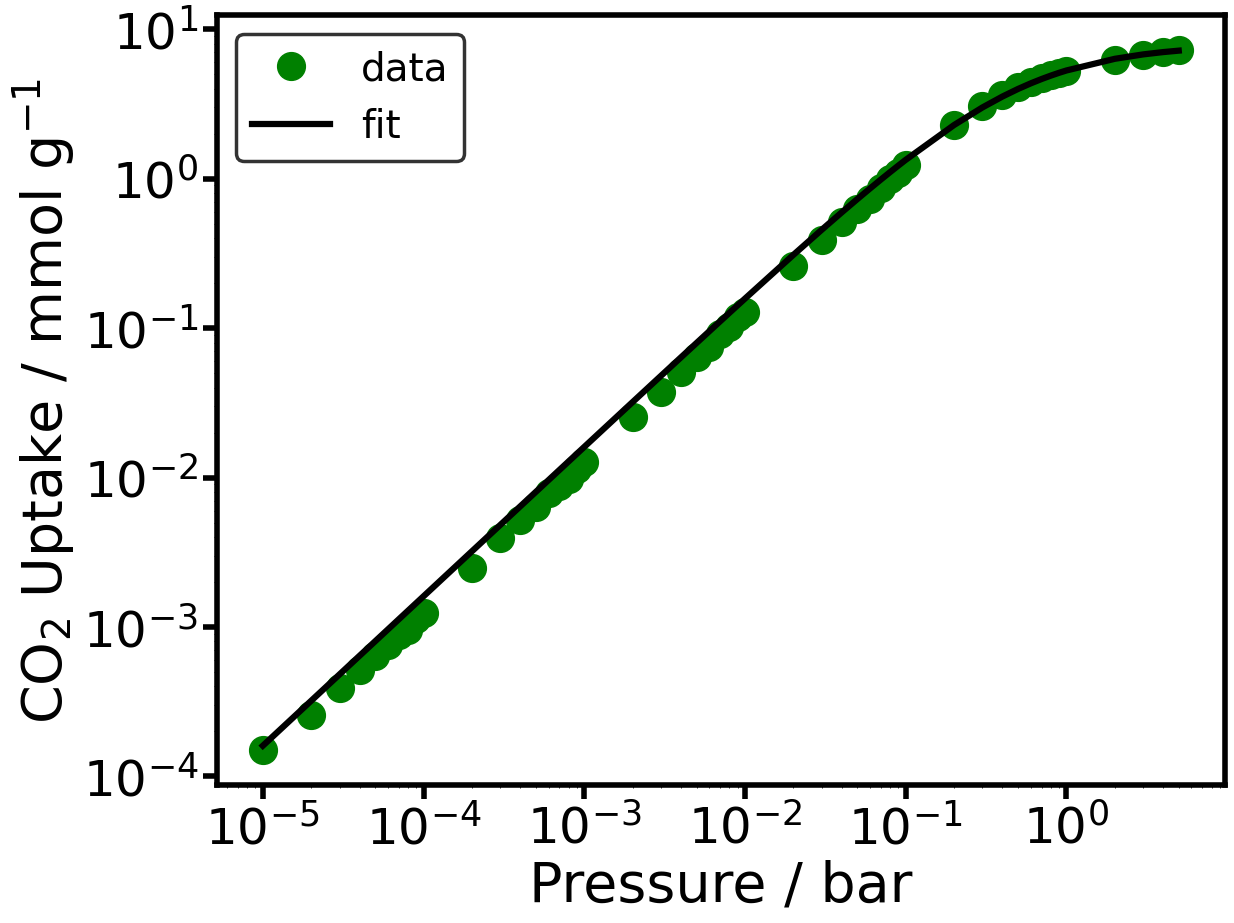

0.99929298258059
FumCALF-20_MACE_opt_pacman finish


In [7]:
ref_params_list_CO2 = []

for name1 in final_structure_name_list:
        
    print(f"{name1} start")
    
    CO2_data_298_rere = str(name1)+"_CO2_298K.csv"
    df9 = pd.read_csv(CO2_data_298_rere)
    
    ## set proper initial guess
    
    init_value = max(df9["q"])
    
    if init_value >= 2.00:
        
        init_value1 = init_value/2
        init_value2 = init_value/3
    
    else:
        
        init_value1 = init_value
        init_value2 = init_value
    
    ## First of all, obtain isotherm parameters at reference temperature
    
    try:
        
        print("first try")
        
        pars, pcov = curve_fit(DL_eq_ref, df9["P"], df9["q"], p0=[init_value1, init_value2, 0, 0, -20000, -20000], maxfev = 100000) 
        
        q_pred = DL_eq_ref(df9["P"], *pars)
        r2 = r2_score(q_pred, df9["q"])
        
        if float(pars[0]) >= 1e2 or float(pars[1]) >= 1e2 or float(pars[0]) < 0 or float(pars[1]) < 0 or float(pars[2]) < 0 or float(pars[3]) < 0 or float(pars[4]) > 0 or float(pars[5]) > 0:
        
            raise Exception("wrong parameter")
            
        if r2 < 0.99:
            
            raise Exception("not best parameter")
        
    except:
        try:
            
            print("second try")
            
            pars, pcov = curve_fit(DL_eq_ref, df9["P"], df9["q"], p0=[init_value1, init_value2, 0, 0, -25000, -25000], maxfev = 100000) 
            
            q_pred = DL_eq_ref(df9["P"], *pars)
            r2 = r2_score(q_pred, df9["q"])
            
            if float(pars[0]) >= 1e2 or float(pars[1]) >= 1e2 or float(pars[0]) < 0 or float(pars[1]) < 0 or float(pars[2]) < 0 or float(pars[3]) < 0 or float(pars[4]) > 0 or float(pars[5]) > 0:
        
                raise Exception("wrong parameter")
        
            if r2 < 0.99:
            
                raise Exception("not best parameter")
        
        except:
            try:
                
                print("third try")
                
                pars, pcov = curve_fit(DL_eq_ref, df9["P"], df9["q"], p0=[init_value1, init_value2, 0, 0, -30000, -30000], maxfev = 100000) 
                
                q_pred = DL_eq_ref(df9["P"], *pars)
                r2 = r2_score(q_pred, df9["q"])
                
                if float(pars[0]) >= 1e2 or float(pars[1]) >= 1e2 or float(pars[0]) < 0 or float(pars[1]) < 0 or float(pars[2]) < 0 or float(pars[3]) < 0 or float(pars[4]) > 0 or float(pars[5]) > 0:
        
                    raise Exception("wrong parameter")
            
                if r2 < 0.99:
            
                    raise Exception("not best parameter")
            
            except:
                try:
                    
                    print("fourth try")
                    
                    pars, pcov = curve_fit(DL_eq_ref, df9["P"], df9["q"], p0=[init_value1, init_value2, 0, 0, -35000, -35000], maxfev = 100000) 
                    
                    q_pred = DL_eq_ref(df9["P"], *pars)
                    r2 = r2_score(q_pred, df9["q"])
                    
                    if float(pars[0]) >= 1e2 or float(pars[1]) >= 1e2 or float(pars[0]) < 0 or float(pars[1]) < 0 or float(pars[2]) < 0 or float(pars[3]) < 0 or float(pars[4]) > 0 or float(pars[5]) > 0:
        
                        raise Exception("wrong parameter")
            
                    if r2 < 0.99:
            
                        raise Exception("not best parameter")

                except:
                    try:
                        
                        print("fifth try")
                        
                        pars, pcov = curve_fit(DL_eq_ref, df9["P"], df9["q"], p0=[init_value1, init_value2, 0, 0, -40000, -40000], maxfev = 100000) 
                        
                        q_pred = DL_eq_ref(df9["P"], *pars)
                        r2 = r2_score(q_pred, df9["q"])
                        
                        if float(pars[0]) >= 1e2 or float(pars[1]) >= 1e2 or float(pars[0]) < 0 or float(pars[1]) < 0 or float(pars[2]) < 0 or float(pars[3]) < 0 or float(pars[4]) > 0 or float(pars[5]) > 0:
        
                            raise Exception("wrong parameter")
            
                        if r2 < 0.99:
            
                            raise Exception("not best parameter")
                        
                    except:
                        try:
                        
                            print("sixth try")
                        
                            pars, pcov = curve_fit(DL_eq_ref, df9["P"], df9["q"], p0=[init_value1, init_value2, 0, 0, -45000, -45000], maxfev = 100000) 
                            
                            q_pred = DL_eq_ref(df9["P"], *pars)
                            r2 = r2_score(q_pred, df9["q"])
                            
                            if float(pars[0]) >= 1e2 or float(pars[1]) >= 1e2 or float(pars[0]) < 0 or float(pars[1]) < 0 or float(pars[2]) < 0 or float(pars[3]) < 0 or float(pars[4]) > 0 or float(pars[5]) > 0:
        
                                raise Exception("wrong parameter")
            
                            if r2 < 0.99:

                                raise Exception("not best parameter")
                        
                        except:
                            try:

                                print("seventh try")

                                pars, pcov = curve_fit(DL_eq_ref, df9["P"], df9["q"], p0=[init_value1, init_value2, 0, 0, -50000, -50000], maxfev = 100000) 
                                
                                q_pred = DL_eq_ref(df9["P"], *pars)
                                r2 = r2_score(q_pred, df9["q"])
                                
                                if float(pars[0]) >= 1e2 or float(pars[1]) >= 1e2 or float(pars[0]) < 0 or float(pars[1]) < 0 or float(pars[2]) < 0 or float(pars[3]) < 0 or float(pars[4]) > 0 or float(pars[5]) > 0:

                                    raise Exception("wrong parameter")
                                    
                                if r2 < 0.99:
            
                                    raise Exception("not best parameter")

                            except:
                                try:

                                    print("eighth try")

                                    pars, pcov = curve_fit(DL_eq_ref, df9["P"], df9["q"], p0=[init_value1, 0, 0, 0, -20000, 0], maxfev = 100000) 
                                    
                                    q_pred = DL_eq_ref(df9["P"], *pars)
                                    r2 = r2_score(q_pred, df9["q"])
                                    
                                    if float(pars[0]) >= 1e2 or float(pars[1]) >= 1e2 or float(pars[0]) < 0 or float(pars[1]) < 0 or float(pars[2]) < 0 or float(pars[3]) < 0 or float(pars[4]) > 0 or float(pars[5]) > 0:

                                        raise Exception("wrong parameter")
                                        
                                    if r2 < 0.99:
            
                                        raise Exception("not best parameter")
                                
                                except:
                                    
                                    print("nineth try")

                                    pars, pcov = curve_fit(DL_eq_ref, df9["P"], df9["q"], p0=[init_value1, 0, 0, 0, -25000, 0], maxfev = 100000) 

                                    q_pred = DL_eq_ref(df9["P"], *pars)
                                    r2 = r2_score(q_pred, df9["q"])
                                    
                                    if float(pars[0]) >= 1e2 or float(pars[1]) >= 1e2 or float(pars[0]) < 0 or float(pars[1]) < 0 or float(pars[2]) < 0 or float(pars[3]) < 0 or float(pars[4]) > 0 or float(pars[5]) > 0:

                                        raise Exception("wrong parameter")
                                        
                                    if r2 < 0.99:
            
                                        raise Exception("not best parameter")
    
    ## show the parameter
    
    parameter_ref_tem = pars
    print(parameter_ref_tem)
    ref_params_list_CO2.append(parameter_ref_tem)
    
    ## draw the fitted isotherm
    
    plt.figure(figsize =(13,10)) 
    ax5 = plt.subplot(1,1,1)
    
    ax5.plot(df9["P"]/100000, df9["q"], lw=0, marker='o', markersize=20, color='green', label='data')
    ax5.plot(df9["P"]/100000, DL_eq_ref(df9["P"], *parameter_ref_tem), lw=4.5, color='black', label='fit')
    
    plt.semilogx()
    plt.semilogy()
    #ax.set_xlim(-0.1,10.1)
    #plt. ylim(-0.05,7)
    
    plt. xticks(fontsize=36)
    plt. tick_params(axis='both', width=4, length=10)
    plt. yticks(fontsize=36)
    
    for axis in ['top','bottom','left','right']:
        ax5.spines[axis].set_linewidth(4)

    ax5.set_xlabel('Pressure / bar', fontsize=40)
    ax5.set_ylabel('CO$_{2}$ Uptake / mmol g$^{{\u2212}1}$', fontsize=40)
    
    leg=plt.legend(frameon=True, fontsize=28, loc='best')
    #bbox_to_anchor=(1, 0.18)
    leg.get_frame_on()
    leg.get_frame().set_linewidth(2.5)
    leg.get_frame().set_edgecolor('black')
    
    ## save fitting result
    
    plt.savefig(f"./fit_result_{name1}_CO2_298K.png", format='png', dpi=300)
    
    plt.show()
    print(r2)
    print(f"{name1} finish")

FumCALF-20_MACE_opt_pacman start
[0.3767793985076105]
first try
second try
third try
fourth try
[ 4.33791219e+00  3.43064066e+00  1.16010018e-10  1.73675986e-10
 -2.99999884e+04 -2.89999942e+04]


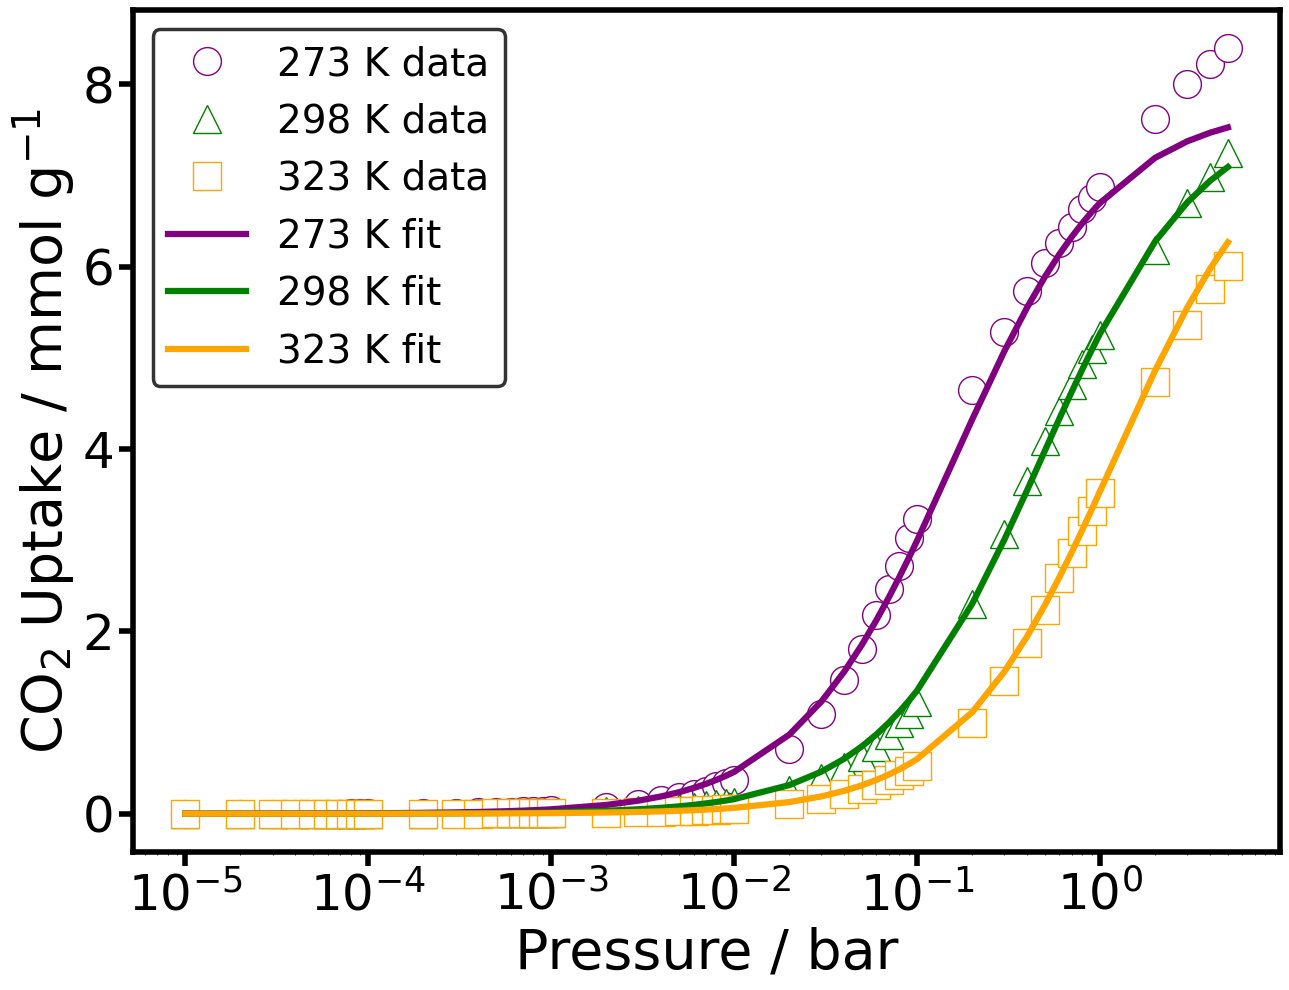

r_square for FumCALF-20_MACE_opt_pacman:0.999488486189755
RMSE for FumCALF-20_MACE_opt_pacman:0.053352287435878
FumCALF-20_MACE_opt_pacman finish


In [10]:
final_params_list_CO2 = []
scaling_params_list_CO2 = []
R2_list_CO2 = []
RMSE_list_CO2 = []

R2_cri = 0.99
RMSE_cri = 0.15

for i, name2 in enumerate(final_structure_name_list): 
    
    print(f"{name2} start")
    
    ## load data at reference temperature
    CO2_data_273_rere = str(name2)+"_CO2_273K.csv"
    CO2_data_298_rere = str(name2)+"_CO2_298K.csv"
    CO2_data_323_rere = str(name2)+"_CO2_323K.csv"
    
    df10 = pd.read_csv(CO2_data_273_rere)
    df11 = pd.read_csv(CO2_data_298_rere)
    df12 = pd.read_csv(CO2_data_323_rere)
    
    parameter_ref_tem = ref_params_list_CO2[i]
    
    qb1 = parameter_ref_tem[0]
    qd1 = parameter_ref_tem[1]
    b1  = parameter_ref_tem[2]
    d1  = parameter_ref_tem[3]
    Ub1 = parameter_ref_tem[4]
    Ud1 = parameter_ref_tem[5]
    
    ## get scaling factors and the scaled isotherm data

    ## get scaling factor

    #pars1, pcov1 = curve_fit(DL_th_eq_ref, df11["P"], df11["q"], [1])
    #parameter_298 = pars1

    pars2, pcov2 = curve_fit(DL_th_eq_ref, df12["P"], df12["q"], [0.5])
    parameter_323 = pars2

    scaling_factor_list = [parameter_323[0]]
    print(scaling_factor_list)
    scaling_params_list_CO2.append(scaling_factor_list)

    ## gather all data

    #df_273 = pd.DataFrame({"P":df10["P"], "q":df10["q"]})

    df_298 = pd.DataFrame({"P":df11["P"], "q": df11["q"]})

    df_323 = pd.DataFrame({"P":parameter_323[0]*df12["P"], "q": df12["q"]})

    #df_gather1 = df_298.append(df_273, ignore_index = True)
    #df_all_tem_data = df_gather1.append(df_323, ignore_index = True)

    #f_gather1 = pd.concat([df_273, df_298], ignore_index=True)
    df_all_tem_data = pd.concat([df_298, df_323], ignore_index=True)
    
    #df_all_tem_data = df_360.append(df_423, ignore_index = True)
    
    ## get final isotherm parameter using scaled isotherm data
    
    init_value = max(df_all_tem_data["q"])
    
    if init_value >= 2.00:
        
        init_value1 = init_value/2+0.5
        init_value2 = init_value/2-0.5
    
    else:
        
        init_value1 = init_value/2
        init_value2 = init_value/2
    
    ## First of all, obtain isotherm parameters at reference temperature
    
    try:
        
        print("first try")
        
        pars, pcov = curve_fit(DL_eq_ref, df_all_tem_data["P"], df_all_tem_data["q"], [init_value1, init_value2, 0, 0, -15000, -14000], maxfev = 100000) 
    
        if float(pars[0]) >= 1e2 or float(pars[1]) >= 1e2 or float(pars[0]) < 0 or float(pars[1]) < 0 or float(pars[2]) < 0 or float(pars[3]) < 0 or float(pars[4]) > 0 or float(pars[5]) > 0:
        
            raise Exception("wrong parameter")
        
        if R2_RMSE_fun(df11, df12, pars)[0] < R2_cri or R2_RMSE_fun(df11, df12, pars)[1] > RMSE_cri:
            
            raise Exception("not best parameter")
        
    except:
        try:
            
            print("second try")
            
            pars, pcov = curve_fit(DL_eq_ref, df_all_tem_data["P"], df_all_tem_data["q"], [init_value1, init_value2, 0, 0, -20000, -19000], maxfev = 100000) 
        
            if float(pars[0]) >= 1e2 or float(pars[1]) >= 1e2 or float(pars[0]) < 0 or float(pars[1]) < 0 or float(pars[2]) < 0 or float(pars[3]) < 0 or float(pars[4]) > 0 or float(pars[5]) > 0:
        
                raise Exception("wrong parameter")
            
            if R2_RMSE_fun(df11, df12, pars)[0] < R2_cri or R2_RMSE_fun(df11, df12, pars)[1] > RMSE_cri:
            
                raise Exception("not best parameter")
        
        except:
            try:
                
                print("third try")
                
                pars, pcov = curve_fit(DL_eq_ref, df_all_tem_data["P"], df_all_tem_data["q"], [init_value1, init_value2, 0, 0, -25000, -24000], maxfev = 100000) 
            
                if float(pars[0]) >= 1e2 or float(pars[1]) >= 1e2 or float(pars[0]) < 0 or float(pars[1]) < 0 or float(pars[2]) < 0 or float(pars[3]) < 0 or float(pars[4]) > 0 or float(pars[5]) > 0:
        
                    raise Exception("wrong parameter")
                
                if R2_RMSE_fun(df11, df12, pars)[0] < R2_cri or R2_RMSE_fun(df11, df12, pars)[1] > RMSE_cri:
            
                    raise Exception("not best parameter")
            
            except:
                try:
                    
                    print("fourth try")
                    
                    pars, pcov = curve_fit(DL_eq_ref, df_all_tem_data["P"], df_all_tem_data["q"], [init_value1, init_value2, 0, 0, -30000, -29000], maxfev = 100000) 
                
                    if float(pars[0]) >= 1e2 or float(pars[1]) >= 1e2 or float(pars[0]) < 0 or float(pars[1]) < 0 or float(pars[2]) < 0 or float(pars[3]) < 0 or float(pars[4]) > 0 or float(pars[5]) > 0:
        
                        raise Exception("wrong parameter")
                
                    if R2_RMSE_fun(df11, df12, pars)[0] < R2_cri or R2_RMSE_fun(df11, df12, pars)[1] > RMSE_cri:
            
                        raise Exception("not best parameter")
                
                except:
                    try:
                        
                        print("fifth try")
                        
                        pars, pcov = curve_fit(DL_eq_ref, df_all_tem_data["P"], df_all_tem_data["q"], [init_value1, init_value2, 0, 0, -35000, -34000], maxfev = 100000) 
                        
                        if float(pars[0]) >= 1e2 or float(pars[1]) >= 1e2 or float(pars[0]) < 0 or float(pars[1]) < 0 or float(pars[2]) < 0 or float(pars[3]) < 0 or float(pars[4]) > 0 or float(pars[5]) > 0:
        
                            raise Exception("wrong parameter")
                        
                        if R2_RMSE_fun(df11, df12, pars)[0] < R2_cri or R2_RMSE_fun(df11, df12, pars)[1] > RMSE_cri:
            
                            raise Exception("not best parameter")
                
                    except:
                        try:
                        
                            print("sixth try")
                        
                            pars, pcov = curve_fit(DL_eq_ref, df_all_tem_data["P"], df_all_tem_data["q"], [init_value1, init_value2, 0, 0, -40000, -39000], maxfev = 100000) 
                        
                            if float(pars[0]) >= 1e2 or float(pars[1]) >= 1e2 or float(pars[0]) < 0 or float(pars[1]) < 0 or float(pars[2]) < 0 or float(pars[3]) < 0 or float(pars[4]) > 0 or float(pars[5]) > 0:
        
                                raise Exception("wrong parameter")
                        
                            if R2_RMSE_fun(df11, df12, pars)[0] < R2_cri or R2_RMSE_fun(df11, df12, pars)[1] > RMSE_cri:
            
                                raise Exception("not best parameter")
                        
                        except:
                            try:

                                print("seventh try")

                                pars, pcov = curve_fit(DL_eq_ref, df_all_tem_data["P"], df_all_tem_data["q"], [init_value1, init_value2, 0, 0, -45000, -44000], maxfev = 100000) 

                                if float(pars[0]) >= 1e2 or float(pars[1]) >= 1e2 or float(pars[0]) < 0 or float(pars[1]) < 0 or float(pars[2]) < 0 or float(pars[3]) < 0 or float(pars[4]) > 0 or float(pars[5]) > 0:

                                    raise Exception("wrong parameter")

                                if R2_RMSE_fun(df11, df12, pars)[0] < R2_cri or R2_RMSE_fun(df11, df12, pars)[1] > RMSE_cri:

                                    raise Exception("not best parameter")

                            except:
                                try:

                                    print("eighth try")

                                    pars, pcov = curve_fit(DL_eq_ref, df_all_tem_data["P"], df_all_tem_data["q"], [init_value1, init_value2, 0, 0, -50000, -49000], maxfev = 100000) 

                                    if float(pars[0]) >= 1e2 or float(pars[1]) >= 1e2 or float(pars[0]) < 0 or float(pars[1]) < 0 or float(pars[2]) < 0 or float(pars[3]) < 0 or float(pars[4]) > 0 or float(pars[5]) > 0:

                                        raise Exception("wrong parameter")

                                    if R2_RMSE_fun(df11, df12, pars)[0] < R2_cri or R2_RMSE_fun(df11, df12, pars)[1] > RMSE_cri:

                                        raise Exception("not best parameter")
                                        
                                except:
                                    try:
                                           
                                        print("nineth try")

                                        pars, pcov = curve_fit(DL_eq_ref, df_all_tem_data["P"], df_all_tem_data["q"], [init_value1, init_value2, 0, 0, -55000, -54000], maxfev = 100000) 

                                        if float(pars[0]) >= 1e2 or float(pars[1]) >= 1e2 or float(pars[0]) < 0 or float(pars[1]) < 0 or float(pars[2]) < 0 or float(pars[3]) < 0 or float(pars[4]) > 0 or float(pars[5]) > 0:

                                            raise Exception("wrong parameter")

                                        if R2_RMSE_fun(df11, df12, pars)[0] < R2_cri or R2_RMSE_fun(df11, df12, pars)[1] > RMSE_cri:

                                            raise Exception("not best parameter")
                                        
                                    except:
                                    
                                        pars = parameter_ref_tem                    
    
    ## show the parameter
    
    parameter_final = pars
    print(parameter_final)
    final_params_list_CO2.append(parameter_final)

    ## draw the fitted isotherm at all temperatures
    
    plt.figure(figsize =(13,10)) 
    ax6 = plt.subplot(1,1,1)

    ax6.plot(df10["P"]/100000, df10["q"], lw=0, marker='o', markerfacecolor = 'white', markersize=20, color='purple', label='273 K data')
    ax6.plot(df11["P"]/100000, df11["q"], lw=0, marker='^', markerfacecolor = 'white', markersize=20, color='green', label='298 K data')
    ax6.plot(df12["P"]/100000, df12["q"], lw=0, marker='s', markerfacecolor = 'white', markersize=20, color='orange', label='323 K data')

    ax6.plot(df10["P"]/100000, DL_eq_ori(df10["P"], 273, *parameter_final), lw=4.5, color='purple', label='273 K fit')
    ax6.plot(df11["P"]/100000, DL_eq_ori(df11["P"], 298, *parameter_final), lw=4.5, color='green', label='298 K fit')
    ax6.plot(df12["P"]/100000, DL_eq_ori(df12["P"], 323, *parameter_final), lw=4.5, color='orange', label='323 K fit')

    plt.semilogx()
    #plt.semilogy()
    #ax.set_xlim(-0.1,10.1)
    #plt. ylim(-0.05,7)
    plt. xticks(fontsize=36)
    plt. tick_params(axis='both', width=4, length=10)
    plt. yticks(fontsize=36)

    for axis in ['top','bottom','left','right']:
        ax6.spines[axis].set_linewidth(4)

    ax6.set_xlabel('Pressure / bar', fontsize=40)
    ax6.set_ylabel('CO$_{2}$ Uptake / mmol g$^{{\u2212}1}$', fontsize=40)

    leg=plt.legend(frameon=True, fontsize=28, loc='best')
    #bbox_to_anchor=(1, 0.18)
    leg.get_frame_on()
    leg.get_frame().set_linewidth(2.5)
    leg.get_frame().set_edgecolor('black')
    
    plt.tight_layout()

    ## save fitting result

    plt.savefig(f"./fit_result_final_{name2}_CO2_ref_298K.png", format='png', dpi=300)
    plt.show()

    ## calculate R2 and RMSE
    R2, RMSE = R2_RMSE_fun(df11, df12, parameter_final)
    print(f"r_square for {name2}:"+str(R2))
    print(f"RMSE for {name2}:"+str(RMSE))
    
    R2_list_CO2.append(R2)
    RMSE_list_CO2.append(RMSE)
    
    print(f"{name2} finish")

FumCALF-20_MACE_opt_pacman start
[0.3767793985076105]
first try
second try
third try
fourth try
[ 4.33791219e+00  3.43064066e+00  1.16010018e-10  1.73675986e-10
 -2.99999884e+04 -2.89999942e+04]


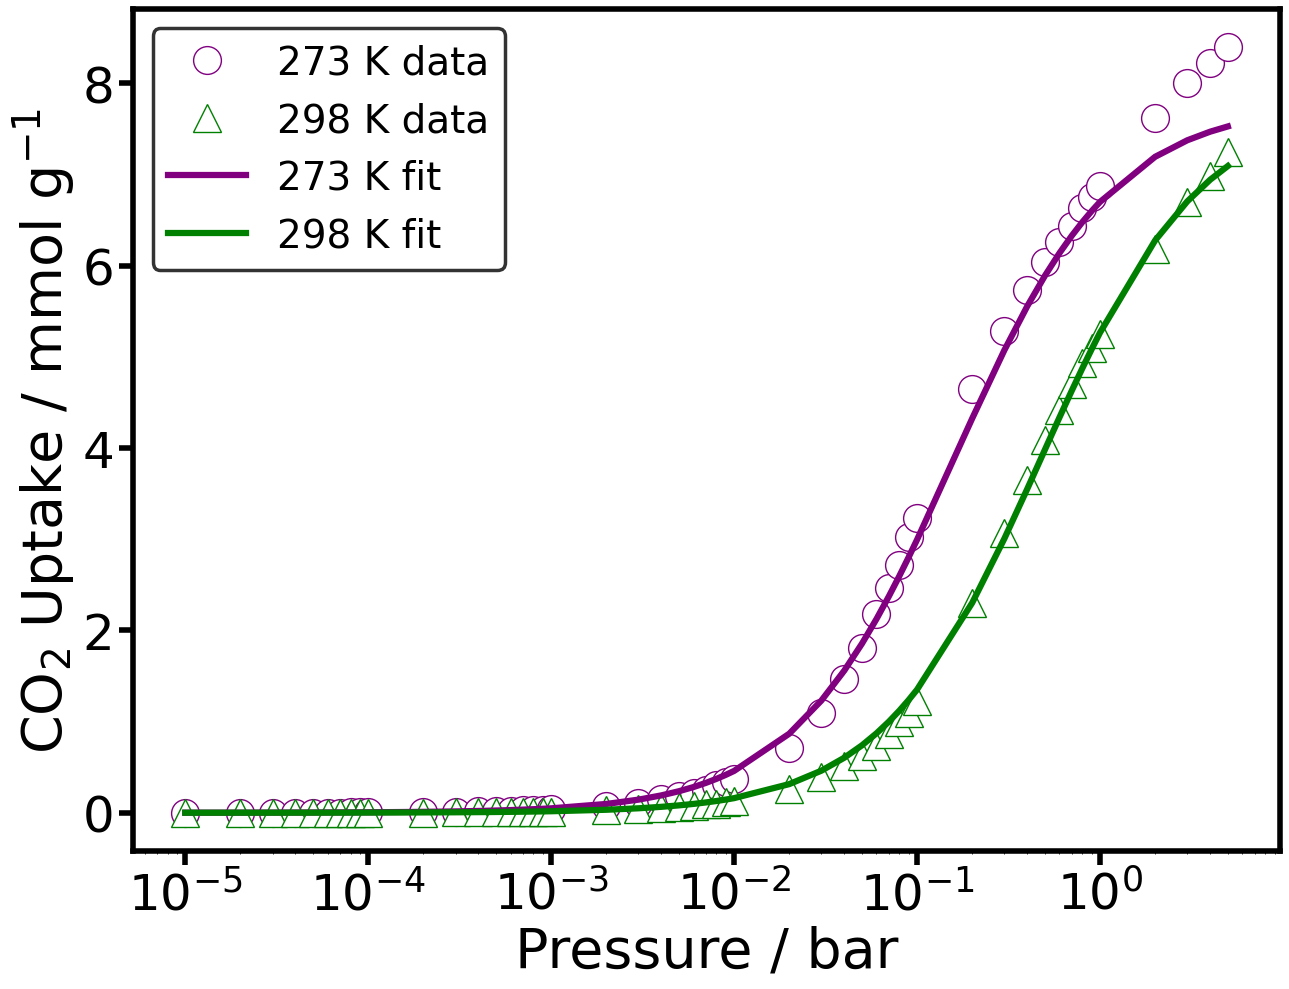

r_square for FumCALF-20_MACE_opt_pacman:0.8433338851500266
RMSE for FumCALF-20_MACE_opt_pacman:1.065636468741743
FumCALF-20_MACE_opt_pacman finish


In [9]:
final_params_list_CO2 = []
scaling_params_list_CO2 = []
R2_list_CO2 = []
RMSE_list_CO2 = []

R2_cri = 0.99
RMSE_cri = 0.15

for i, name2 in enumerate(final_structure_name_list): 
    
    print(f"{name2} start")
    
    ## load data at reference temperature
    CO2_data_273_rere = str(name2)+"_CO2_273K.csv"
    CO2_data_298_rere = str(name2)+"_CO2_298K.csv"
    CO2_data_323_rere = str(name2)+"_CO2_323K.csv"
    
    df10 = pd.read_csv(CO2_data_273_rere)
    df11 = pd.read_csv(CO2_data_298_rere)
    df12 = pd.read_csv(CO2_data_323_rere)
    
    parameter_ref_tem = ref_params_list_CO2[i]
    
    qb1 = parameter_ref_tem[0]
    qd1 = parameter_ref_tem[1]
    b1  = parameter_ref_tem[2]
    d1  = parameter_ref_tem[3]
    Ub1 = parameter_ref_tem[4]
    Ud1 = parameter_ref_tem[5]
    
    ## get scaling factors and the scaled isotherm data

    ## get scaling factor

    #pars1, pcov1 = curve_fit(DL_th_eq_ref, df11["P"], df11["q"], [1])
    #parameter_298 = pars1

    pars2, pcov2 = curve_fit(DL_th_eq_ref, df12["P"], df12["q"], [0.5])
    parameter_273 = pars2

    scaling_factor_list = [parameter_273[0]]
    print(scaling_factor_list)
    scaling_params_list_CO2.append(scaling_factor_list)

    ## gather all data

    #df_273 = pd.DataFrame({"P":df10["P"], "q":df10["q"]})

    df_298 = pd.DataFrame({"P":df11["P"], "q": df11["q"]})

    df_273 = pd.DataFrame({"P":parameter_273[0]*df12["P"], "q": df12["q"]})

    #df_gather1 = df_298.append(df_273, ignore_index = True)
    #df_all_tem_data = df_gather1.append(df_323, ignore_index = True)

    #f_gather1 = pd.concat([df_273, df_298], ignore_index=True)
    df_all_tem_data = pd.concat([df_298, df_273], ignore_index=True)
    
    #df_all_tem_data = df_360.append(df_423, ignore_index = True)
    
    ## get final isotherm parameter using scaled isotherm data
    
    init_value = max(df_all_tem_data["q"])
    
    if init_value >= 2.00:
        
        init_value1 = init_value/2+0.5
        init_value2 = init_value/2-0.5
    
    else:
        
        init_value1 = init_value/2
        init_value2 = init_value/2
    
    ## First of all, obtain isotherm parameters at reference temperature
    
    try:
        
        print("first try")
        
        pars, pcov = curve_fit(DL_eq_ref, df_all_tem_data["P"], df_all_tem_data["q"], [init_value1, init_value2, 0, 0, -15000, -14000], maxfev = 100000) 
    
        if float(pars[0]) >= 1e2 or float(pars[1]) >= 1e2 or float(pars[0]) < 0 or float(pars[1]) < 0 or float(pars[2]) < 0 or float(pars[3]) < 0 or float(pars[4]) > 0 or float(pars[5]) > 0:
        
            raise Exception("wrong parameter")
        
        if R2_RMSE_fun(df11, df12, pars)[0] < R2_cri or R2_RMSE_fun(df11, df12, pars)[1] > RMSE_cri:
            
            raise Exception("not best parameter")
        
    except:
        try:
            
            print("second try")
            
            pars, pcov = curve_fit(DL_eq_ref, df_all_tem_data["P"], df_all_tem_data["q"], [init_value1, init_value2, 0, 0, -20000, -19000], maxfev = 100000) 
        
            if float(pars[0]) >= 1e2 or float(pars[1]) >= 1e2 or float(pars[0]) < 0 or float(pars[1]) < 0 or float(pars[2]) < 0 or float(pars[3]) < 0 or float(pars[4]) > 0 or float(pars[5]) > 0:
        
                raise Exception("wrong parameter")
            
            if R2_RMSE_fun(df11, df12, pars)[0] < R2_cri or R2_RMSE_fun(df11, df12, pars)[1] > RMSE_cri:
            
                raise Exception("not best parameter")
        
        except:
            try:
                
                print("third try")
                
                pars, pcov = curve_fit(DL_eq_ref, df_all_tem_data["P"], df_all_tem_data["q"], [init_value1, init_value2, 0, 0, -25000, -24000], maxfev = 100000) 
            
                if float(pars[0]) >= 1e2 or float(pars[1]) >= 1e2 or float(pars[0]) < 0 or float(pars[1]) < 0 or float(pars[2]) < 0 or float(pars[3]) < 0 or float(pars[4]) > 0 or float(pars[5]) > 0:
        
                    raise Exception("wrong parameter")
                
                if R2_RMSE_fun(df11, df12, pars)[0] < R2_cri or R2_RMSE_fun(df11, df12, pars)[1] > RMSE_cri:
            
                    raise Exception("not best parameter")
            
            except:
                try:
                    
                    print("fourth try")
                    
                    pars, pcov = curve_fit(DL_eq_ref, df_all_tem_data["P"], df_all_tem_data["q"], [init_value1, init_value2, 0, 0, -30000, -29000], maxfev = 100000) 
                
                    if float(pars[0]) >= 1e2 or float(pars[1]) >= 1e2 or float(pars[0]) < 0 or float(pars[1]) < 0 or float(pars[2]) < 0 or float(pars[3]) < 0 or float(pars[4]) > 0 or float(pars[5]) > 0:
        
                        raise Exception("wrong parameter")
                
                    if R2_RMSE_fun(df11, df12, pars)[0] < R2_cri or R2_RMSE_fun(df11, df12, pars)[1] > RMSE_cri:
            
                        raise Exception("not best parameter")
                
                except:
                    try:
                        
                        print("fifth try")
                        
                        pars, pcov = curve_fit(DL_eq_ref, df_all_tem_data["P"], df_all_tem_data["q"], [init_value1, init_value2, 0, 0, -35000, -34000], maxfev = 100000) 
                        
                        if float(pars[0]) >= 1e2 or float(pars[1]) >= 1e2 or float(pars[0]) < 0 or float(pars[1]) < 0 or float(pars[2]) < 0 or float(pars[3]) < 0 or float(pars[4]) > 0 or float(pars[5]) > 0:
        
                            raise Exception("wrong parameter")
                        
                        if R2_RMSE_fun(df11, df12, pars)[0] < R2_cri or R2_RMSE_fun(df11, df12, pars)[1] > RMSE_cri:
            
                            raise Exception("not best parameter")
                
                    except:
                        try:
                        
                            print("sixth try")
                        
                            pars, pcov = curve_fit(DL_eq_ref, df_all_tem_data["P"], df_all_tem_data["q"], [init_value1, init_value2, 0, 0, -40000, -39000], maxfev = 100000) 
                        
                            if float(pars[0]) >= 1e2 or float(pars[1]) >= 1e2 or float(pars[0]) < 0 or float(pars[1]) < 0 or float(pars[2]) < 0 or float(pars[3]) < 0 or float(pars[4]) > 0 or float(pars[5]) > 0:
        
                                raise Exception("wrong parameter")
                        
                            if R2_RMSE_fun(df11, df12, pars)[0] < R2_cri or R2_RMSE_fun(df11, df12, pars)[1] > RMSE_cri:
            
                                raise Exception("not best parameter")
                        
                        except:
                            try:

                                print("seventh try")

                                pars, pcov = curve_fit(DL_eq_ref, df_all_tem_data["P"], df_all_tem_data["q"], [init_value1, init_value2, 0, 0, -45000, -44000], maxfev = 100000) 

                                if float(pars[0]) >= 1e2 or float(pars[1]) >= 1e2 or float(pars[0]) < 0 or float(pars[1]) < 0 or float(pars[2]) < 0 or float(pars[3]) < 0 or float(pars[4]) > 0 or float(pars[5]) > 0:

                                    raise Exception("wrong parameter")

                                if R2_RMSE_fun(df11, df12, pars)[0] < R2_cri or R2_RMSE_fun(df11, df12, pars)[1] > RMSE_cri:

                                    raise Exception("not best parameter")

                            except:
                                try:

                                    print("eighth try")

                                    pars, pcov = curve_fit(DL_eq_ref, df_all_tem_data["P"], df_all_tem_data["q"], [init_value1, init_value2, 0, 0, -50000, -49000], maxfev = 100000) 

                                    if float(pars[0]) >= 1e2 or float(pars[1]) >= 1e2 or float(pars[0]) < 0 or float(pars[1]) < 0 or float(pars[2]) < 0 or float(pars[3]) < 0 or float(pars[4]) > 0 or float(pars[5]) > 0:

                                        raise Exception("wrong parameter")

                                    if R2_RMSE_fun(df11, df12, pars)[0] < R2_cri or R2_RMSE_fun(df11, df12, pars)[1] > RMSE_cri:

                                        raise Exception("not best parameter")
                                        
                                except:
                                    try:
                                           
                                        print("nineth try")

                                        pars, pcov = curve_fit(DL_eq_ref, df_all_tem_data["P"], df_all_tem_data["q"], [init_value1, init_value2, 0, 0, -55000, -54000], maxfev = 100000) 

                                        if float(pars[0]) >= 1e2 or float(pars[1]) >= 1e2 or float(pars[0]) < 0 or float(pars[1]) < 0 or float(pars[2]) < 0 or float(pars[3]) < 0 or float(pars[4]) > 0 or float(pars[5]) > 0:

                                            raise Exception("wrong parameter")

                                        if R2_RMSE_fun(df11, df12, pars)[0] < R2_cri or R2_RMSE_fun(df11, df12, pars)[1] > RMSE_cri:

                                            raise Exception("not best parameter")
                                        
                                    except:
                                    
                                        pars = parameter_ref_tem                    
    
    ## show the parameter
    
    parameter_final = pars
    print(parameter_final)
    final_params_list_CO2.append(parameter_final)

    ## draw the fitted isotherm at all temperatures
    
    plt.figure(figsize =(13,10)) 
    ax6 = plt.subplot(1,1,1)

    ax6.plot(df10["P"]/100000, df10["q"], lw=0, marker='o', markerfacecolor = 'white', markersize=20, color='purple', label='273 K data')
    ax6.plot(df11["P"]/100000, df11["q"], lw=0, marker='^', markerfacecolor = 'white', markersize=20, color='green', label='298 K data')
    #ax6.plot(df12["P"]/100000, df12["q"], lw=0, marker='s', markerfacecolor = 'white', markersize=20, color='orange', label='323 K data')

    ax6.plot(df10["P"]/100000, DL_eq_ori(df10["P"], 273, *parameter_final), lw=4.5, color='purple', label='273 K fit')
    ax6.plot(df11["P"]/100000, DL_eq_ori(df11["P"], 298, *parameter_final), lw=4.5, color='green', label='298 K fit')
    #ax6.plot(df12["P"]/100000, DL_eq_ori(df12["P"], 323, *parameter_final), lw=4.5, color='orange', label='323 K fit')

    plt.semilogx()
    #plt.semilogy()
    #ax.set_xlim(-0.1,10.1)
    #plt. ylim(-0.05,7)
    plt. xticks(fontsize=36)
    plt. tick_params(axis='both', width=4, length=10)
    plt. yticks(fontsize=36)

    for axis in ['top','bottom','left','right']:
        ax6.spines[axis].set_linewidth(4)

    ax6.set_xlabel('Pressure / bar', fontsize=40)
    ax6.set_ylabel('CO$_{2}$ Uptake / mmol g$^{{\u2212}1}$', fontsize=40)

    leg=plt.legend(frameon=True, fontsize=28, loc='best')
    #bbox_to_anchor=(1, 0.18)
    leg.get_frame_on()
    leg.get_frame().set_linewidth(2.5)
    leg.get_frame().set_edgecolor('black')
    
    plt.tight_layout()

    ## save fitting result

    plt.savefig(f"./fit_result_final_{name2}_CO2_ref_298K_2.png", format='png', dpi=300)
    plt.show()

    ## calculate R2 and RMSE
    R2, RMSE = R2_RMSE_fun(df11, df10, parameter_final)
    print(f"r_square for {name2}:"+str(R2))
    print(f"RMSE for {name2}:"+str(RMSE))
    
    R2_list_CO2.append(R2)
    RMSE_list_CO2.append(RMSE)
    
    print(f"{name2} finish")